# First an OpenCV approach

Let us look at a basic colour segmentation example using OpenCV
There are 4 steps to it-

*   Loading the Image
*   The actual Thresholding of Colour values
*   Resizing 
*   The Final Output

Let us first load the image itself

2020-03-28 13:50:50 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "birb.png" [1]


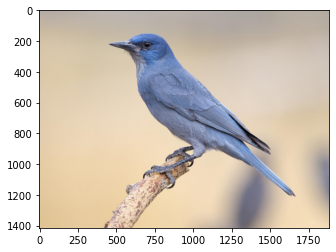

In [0]:
#first a proper opencv approach to segmentation

from PIL import Image
import matplotlib.pyplot as plt
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O birb.png
img = Image.open('./birb.png')
plt.imshow(img)
plt.show()

# Now colab has a bit of an issue with cv2.imshow, so we'll be using a patch by them, very aptly called *cv2_imshow*.

Then, we try and guess the blue filter values for the mask. This is the hardest part, and you can try using the given filters with some of your own images and try tweaking with the values. The hit and trial nature of this method is what gave incentive to try and get a dl approach to things.

In [0]:
from google.colab.patches import cv2_imshow
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
img=cv.imread('birb.png')


##filters for pics
blur = cv.blur(img,(5,5))
blur0=cv.medianBlur(blur,5)
blur1= cv.GaussianBlur(blur0,(5,5),0)
blur2= cv.bilateralFilter(blur1,9,75,75)


##conversions of pics
hsv = cv.cvtColor(blur2, cv.COLOR_BGR2HSV)
gray = cv.cvtColor(blur2, cv.COLOR_BGR2GRAY) 
ret, thresh = cv.threshold(gray, 127, 255, 0)



##for blue
low_blue = np.array([55, 0, 0])
high_blue = np.array([116, 255, 255])
mask = cv.inRange(hsv, low_blue, high_blue)

contours, _=cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

res = cv.bitwise_and(img,img, mask= mask)
res1=cv.cvtColor(res, cv.COLOR_BGR2RGB)

Finally, we'll resize the image, and the mask. The mask itself is actually a transpose of the mask on the original image, so we will get a funky orange bird, which will show how well the filter worked.

In [0]:
scale_percent = 15 # percent of original size
width = int(res1.shape[1] * scale_percent / 100)
height = int(res1.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
smol_mask = cv.resize(res1, dim, interpolation = cv.INTER_AREA) 
scale_percent = 15 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img1 = cv.resize(img, dim, interpolation = cv.INTER_AREA) 

And now time to see how our filter worked!

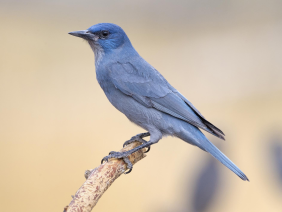

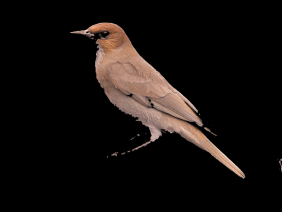

In [0]:
cv2_imshow(img1)
cv2_imshow(smol_mask)

Decently well actually! However, it is no where near as good as industry professionals would like it to be, and we would also need to manually tweak these values for different situations. Enter Deep Learning.

# **THE DL APPROACH**

**NOTE: the next two code cells do not need to be executed, and are only there for demonstration purposes, for now, we will show results via an imported model, and simply give the intuition for how the model is made via these cells. We do however encourage you to try this dummy model out with a dataloader and an optimiser to see how this works when trained manually.**


Let us look at the basic model structure of a unet, and how it helps us for segmentation.
We first have some helper functions **(not the programming sense of functions, just a term to denote the classes)** which will aid us in keeping the final model looking neat and structured.

If there is anything that looks unfamiliar here, do consider refering back to the previous notebook about CNNs [here](https://colab.research.google.com/drive/15ZtX0qeq2IBpBD47G_1guN8HBFJ3TWPN#scrollTo=4AODt7R6bZ06), or alternatively, consider checking [this](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e) out.

There are 4 basic classes here


*   DoubleConv
*   Down
*   Up
*   OutConv

The first class is pretty simple to understand, simply makes one convolution block.

The Down class uses DoubleConv, and adds a maxpool to it

THe Up class does one of two things: either bilinear upscaling, or an inverse convolution process. Over here we have mostly made use of the bilinear upscaling, but it is there, and would have been used in a regular downscaling and upscaling process.

Finally, OutConv takes the final image to upscale it to the original number of channels


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
#helper functions

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

And finally, here we have the model defined using the helper functions from up top. Take note of the UNet structure of the model, where we, during upscaling, call the corresponding downsampling level during upscaling it, and thus, take advantage of the... UNet-ness of the model if I may, by preserving the  detail of the original, and use the same feature maps that are used for contraction to expand the vector to a final segmented image.

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

As for the presentation, lets use a pretrained model, and see how a world class segmentation network perfoms on some sample images. This particular one uses resnet for advanced edge detection. Read about Resnet [here](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)

In [0]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

This is what the intermediate layers of the pretrained model looks like:

In [0]:
fcn.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Let us test on the same bird image we tried on earlier, with ocv. Same bit of code to call the image, and you are welcome to try it out with any other image, simply replace the given url with your image's url.


2020-03-28 13:31:01 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


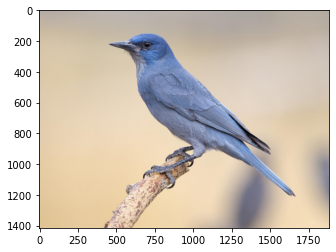

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img)
plt.show()

First, some image processing, by using the helpful functions provided by torchvision.transforms

In [0]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [0]:
out = fcn(inp)['out']
print (inp.shape)
print (out.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 21, 224, 224])


In [0]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


Now let's set up the classes, and the colors which will correspond with each of the classes. It's the index/coordinates of the pixel which are included in the classes, and if the condition is satisfied, then the pixel gets the color code of the defined class.

Basically, all the coordinates/indices which are falling under the category horse, will be changed to the pink color code through the iteration in every pixel of the image.

In [0]:

def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

And now, let's see our output!

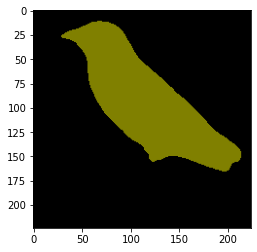

In [0]:
rgb = decode_segmap(om)
plt.imshow(rgb)
plt.show()

Looks a lot better and complete than the ocv method! We did miss the legs, but the bird itself came out whole!

Now let's order this entire process inside one simple function: segment. The code inside this is the same as everything above, just condensed into one function.

In [0]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb)
  plt.axis('off')
  plt.show()
  

And now lets proceed to try this out on a horse!

2020-03-28 13:31:50 URL:https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/horse.jpg [54517/54517] -> "horse.jpg.2" [1]


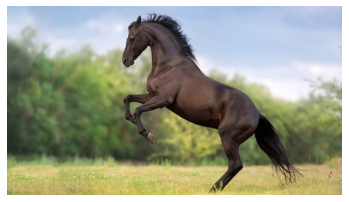

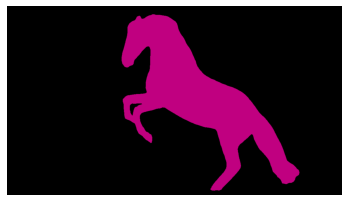

In [0]:
!wget -nv https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/horse.jpg 
#!mv _103224847_horsea.png horse.jpg
img = Image.open('horse.jpg')
segment(fcn, 'horse.jpg')

Brillaint! Again, we strongly reccomend trying out your own image in the following cell if you haven't already.

In [0]:
!wget -nv https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1078084172%2F960x0.jpg 

2020-03-28 13:32:04 URL:https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1078084172%2F960x0.jpg [55550/55550] -> "https:%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1078084172%2F960x0.jpg" [1]


In [0]:
!mv /content/https:%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1078084172%2F960x0.jpg person.jpg

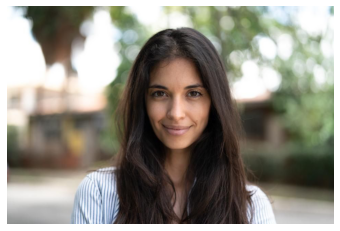

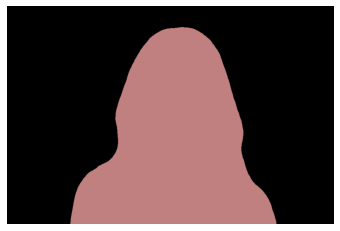

In [0]:
img = Image.open('person.jpg')
out = segment(fcn, 'person.jpg')